In [ ]:
import seaborn as sns
%matplotlib inline

In [1]:
from fastai.datasets import untar_data, URLs
from fastai.text import *

import torch
from tqdm import tqdm_notebook as tqdm

In [2]:
def pad_to_length(in_seq):
    N = 250
    return (in_seq + N * [PAD])[:N]
defaults.text_post_rules.append(pad_to_length)
        
    

In [13]:
path = untar_data(URLs.IMDB_SAMPLE)

In [14]:
import pandas as pd

In [44]:
map_labels = {'negative': 0.0, 'positive': 1.0}

In [46]:
frame = pd.read_csv(path/'texts.csv')
frame['label'] = frame['label'].map(map_labels)
train_frame = frame[~frame['is_valid']]
valid_frame = frame[frame['is_valid']]
print(train_frame.shape, valid_frame.shape)

(800, 3) (200, 3)


In [47]:
dc = TextClasDataBunch.from_df(path, train_df=train_frame,
                               valid_df=valid_frame,
                               test_df=valid_frame,
                               max_vocab=16864, min_freq=1, bs=32)

In [73]:
dc.save('dc_export.pkl')

In [48]:
from pymagnitude import *
vectors = Magnitude('TextDatasets/wiki-news-300d-1M-subword.magnitude')

In [49]:
len(dc.vocab.itos)

13320

In [50]:
len(dc.vocab.stoi)

15128

In [51]:
for ind, word in enumerate(dc.vocab.itos):
    if dc.vocab.stoi[word] != ind:
        print(word, dc.vocab.itos[ind])

In [52]:
weights = torch.from_numpy(vectors.query(dc.vocab.itos))

In [53]:
import torch.nn as nn

In [54]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights, sentence_len, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False,)
        self.conv_layers = [
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_size, embedding_dim)),
                nn.ReLU())
            for filter_size in filter_sizes
        ]
        self.pooling_layers = [nn.MaxPool1d(sentence_len - fs + 1) for fs in filter_sizes]
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        feature_maps = [conv(embedded).squeeze(3) for conv in self.conv_layers]
        pooled_layers = [pool(feature_map).squeeze(2) for pool, feature_map in zip(self.pooling_layers, feature_maps)]
        
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_layers), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat).squeeze()

In [55]:
net = CNN(embedding_dim=300, 
          n_filters=3, filter_sizes=[3,4,5], output_dim=1,
          weights=weights, sentence_len=250, dropout=0.5)

In [56]:
batch = next(iter(dc.train_dl))

In [57]:
loss_func = nn.BCEWithLogitsLoss()

In [68]:
learner = Learner(dc, net, loss_func=loss_func, path=path)

In [69]:
learner.lr_find()

epoch,train_loss,valid_loss,time
0,0.675684,#na#,00:09
1,0.671838,#na#,00:08
2,0.667547,#na#,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


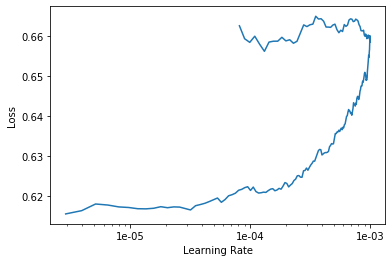

In [77]:
learner.recorder.plot()

In [91]:
learner.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,time
0,0.189241,0.547901,00:10
1,0.182312,0.548723,00:10
2,0.188036,0.554169,00:10
3,0.183066,0.554259,00:11
4,0.175305,0.559235,00:11
5,0.171811,0.564446,00:11
6,0.160707,0.564973,00:11
7,0.151544,0.562882,00:11
8,0.145980,0.563544,00:11
9,0.144357,0.563631,00:11


In [89]:
learner.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,time
0,0.262179,0.564337,00:09
1,0.255560,0.563847,00:11
2,0.254510,0.563067,00:11
3,0.251300,0.562164,00:10
4,0.244391,0.560099,00:11
5,0.237262,0.558560,00:11
6,0.234565,0.557660,00:10
7,0.233208,0.555404,00:11
8,0.231718,0.552635,00:11
9,0.213914,0.552177,00:11


In [90]:
learner.save(path, 'classifier_learner.pkl')

PosixPath('/home/karmanyaaggarwal/.fastai/data/imdb_sample.pth')

In [92]:
learner.load(path, 'classifier_learner.pkl')

RuntimeError: don't know how to restore data location of torch.FloatStorage (tagged with classifier_learner.pkl)

In [95]:
learner.get_preds()

[tensor([0.8166, 0.4628, 0.8912, 0.6159, 0.6169, 0.5685, 0.6547, 0.2220, 0.7013,
         0.1839, 0.1138, 0.3287, 0.0446, 0.3864, 0.4896, 0.5248, 0.2557, 0.5145,
         0.0656, 0.4587, 0.4634, 0.2004, 0.5669, 0.1212, 0.7544, 0.6460, 0.1401,
         0.5532, 0.1260, 0.4408, 0.6253, 0.2494, 0.1117, 0.4869, 0.7310, 0.8167,
         0.6722, 0.1303, 0.6441, 0.5926, 0.8757, 0.7592, 0.7900, 0.2638, 0.8269,
         0.0439, 0.0401, 0.9193, 0.3501, 0.2273, 0.6091, 0.1534, 0.8575, 0.3588,
         0.5660, 0.4419, 0.3870, 0.2812, 0.0697, 0.4117, 0.3820, 0.7653, 0.6367,
         0.2248, 0.1286, 0.2025, 0.4048, 0.6607, 0.3433, 0.8957, 0.8121, 0.0267,
         0.0533, 0.2106, 0.4038, 0.0084, 0.0905, 0.6272, 0.7296, 0.6378, 0.2997,
         0.3433, 0.3511, 0.5573, 0.4454, 0.2585, 0.1693, 0.6638, 0.4008, 0.7619,
         0.4384, 0.8950, 0.2236, 0.2512, 0.4089, 0.1522, 0.1636, 0.1009, 0.8442,
         0.7322, 0.6782, 0.3767, 0.4062, 0.4029, 0.2514, 0.3834, 0.1608, 0.3564,
         0.0330, 0.4989, 0.0

In [101]:
learner.load('classifier_learner')

FileNotFoundError: [Errno 2] No such file or directory: '/home/karmanyaaggarwal/.fastai/data/imdb_sample/models/classifier_learner.pth'

In [102]:
ls .fastai/data/imdb

ls: cannot access '.fastai/data/imdb': No such file or directory


In [103]:
path

PosixPath('/home/karmanyaaggarwal/.fastai/data/imdb_sample')